In [13]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn import metrics
from sklearn.cluster import KMeans

# Helper Functions

For 2 points in 2D space, the Euclidean distance is:

$$d(p_1, p_2) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$$

For points in n-dimensional space (generalized form), the formula is:

$$d(p_1, p_2) = \sqrt{\sum_{i=1}^{n} (p_{1i} - p_{2i})^2}$$

Where:
- $p_1, p_2$ are two points
- $n$ is the number of dimensions
- $p_{1i}, p_{2i}$ are the coordinates in dimension i

Euclidean distance calculation can be computationally intensive for high-dimensional data, which is one of the scalability limitations of k-NN. 
This leads to the "curse of dimensionality" - as dimensions increase, we need exponentially more examples to determine how features distinguish between classes.

In [14]:
def distance(point1, point2) -> float:
    return math.sqrt(((point1[0] - point2[0]) ** 2) + ((point1[1] - point2[1]) ** 2))

# Loading Data

No need to have separate sets for training and testing since we are trying to compare the performance of our K-Means clustering algorithm against the Scikit Learn implementation

In [15]:
iris = load_iris()
X = iris.data [:, [1, 3]] # 1 and 3 are the features we will use here.
y = iris.target

# K-Means Clustering

K-means clustering is an unsupervised learning algorithm used to partition data into K groups or clusters, where data points within a cluster should be similar to each other.

It's used for unsupervised learning tasks where we want to find natural groupings in data without labeled examples. 


The algorithm works by trying to minimize the distance between points and cluster centroids.

For K clusters, the algorithm follows these steps:
1. Pick K initial centroids randomly from the dataset

2. Repeat until convergence:
   - Assign each point to the nearest centroid
   - Update the centroids to be the mean of all points assigned to that cluster 

The objective function being minimized is:

$$J = \sum_{i=1}^{K} \sum_{x \in C_i} ||x - \mu_i||^2$$

Where:
- $K$ is the number of clusters
- $C_i$ represents cluster i
- $\mu_i$ is the centroid (mean) of cluster i
- $x$ represents each data point
- $||x - \mu_i||^2$ is the squared distance between point x and centroid $\mu_i$

We need to estimate the distribution over the number of clusters $p(K|D)$, though this is often simplified by approximating it with its mode:

$$K^* = \arg\max_K p(K|D)$$

Picking the right $K$ is important and is an example of model selection .

## Parameters

In [16]:
clusterNum = 3 
error = 0.01   # convergence is no cluster center moving more than this

## Picking Cluster Centres

Getting the `min` and `max` values fo the features we are trying to cluster

In [17]:
x1_min, x1_max = math.floor(X[:, 0].min()), math.ceil(X[:, 0].max())
x2_min, x2_max =  math.floor(X[:, 1].min()), math.ceil(X[:, 1].max())

## Pick Random Points

Picking random points from the range above as our cluster centres. 

In [18]:
clusters: list[list[int]] = []
for i in range(clusterNum):
    center: list[int] = [random.randrange(x1_min,  x1_max), random.randrange(x2_min,  x2_max)]
    clusters.append(center)


print ("Initial clusters:")
print (clusters)


Initial clusters:
[[4, 0], [3, 2], [3, 1]]


## Training

Running the K-Means algorithm.
First build our own version of the data, `Xcluster`, with an additional element that identifies which cluster the point is in. 
Initiate that cluster to 0.

In [19]:
Xcluster = []
for i in range(len(X)):
    Xcluster.append([X[i], 0])

stop = 0

while stop == 0:
    # Assign each point to the cluster with the nearest centre.
    for i in range(len(Xcluster)):
        distances = []
        # For each data point, compute the distance to each cluster center
        for j in range(len(clusters)):
            distances.append(distance(Xcluster[i][0], clusters[j]))

        # Then assign the point to the cluster with the nearest center.
        if min(distances[0], distances[1], distances[2]) == distances[0]:
            Xcluster[i][1] = 1
        if min(distances[0], distances[1], distances[2]) == distances[1]:
            Xcluster[i][1] = 2
        if min(distances[0], distances[1], distances[2]) == distances[2]:
            Xcluster[i][1] = 3

    # Recompute cluster centres.
    x_coord: list[int]  = [0, 0, 0]
    y_coord: list[int]  = [0, 0, 0]
    counts: list[int]   = [0, 0, 0]

    # Sum up x and y coordinate values of points in each cluster.
    for i in range(len(Xcluster)):
        if Xcluster[i][1] == 1:
            x_coord[0] = x_coord[0] + Xcluster[i][0][0]
            y_coord[0] = y_coord[0] + Xcluster[i][0][1]
            counts[0]  = counts[0] + 1
        if Xcluster[i][1] == 2:
            x_coord[1] = x_coord[1] + Xcluster[i][0][0]
            y_coord[1] = y_coord[1] + Xcluster[i][0][1]
            counts[1]  = counts[1] + 1
        if Xcluster[i][1] == 3:
            x_coord[2] = x_coord[2] + Xcluster[i][0][0]
            y_coord[2] = y_coord[2] + Xcluster[i][0][1]
            counts[2]  = counts[2] + 1

    # Use that to compute new cluster centres and how much each centre
    # moves
    diffs: list[int] = [0, 0, 0]
    for i in range(len(clusters)):
        if counts[i] > 0:
            new_center = [(x_coord[i]/counts[i]), (y_coord[i]/counts[i])]
            diffs[i] = distance(new_center, clusters[i])
            clusters[i] = new_center
   
    # Stop when all centres move less than error
    stop = 1
    for i in range(len(diffs)):
        if diffs[i] > error:
            stop = 0

## Extracting Cluster Identifiers

Extract the cluster identifier into a separate list

In [20]:
labels = []
for i in range(len(Xcluster)):
    labels.append(Xcluster[i][1])

kM_imp: float = metrics.adjusted_rand_score(y, labels)
print ( "Rand index for k-Means implementation: %.4f" % kM_imp )


Rand index for k-Means implementation: 0.7972


## Using Built-In K-Means Algorithm 

In [21]:
kM_X = KMeans(n_clusters = 3)
kM_X.fit(X)
kM_labels = kM_X.labels_
kM_sklearn: float = metrics.adjusted_rand_score(y, kM_labels)
print ("Rand index for k-Means from scikit-learn: %.4f\n" % (kM_sklearn))


Rand index for k-Means from scikit-learn: 0.7972



/home/maruf/.cache/pypoetry/virtualenvs/machine-learning-practicals-tgA2vz9k-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Comparison

Comparing custom K-Means algorithms against built-in to evaluate the performance. 

In [22]:
if kM_sklearn > kM_imp:
    print ("Scikit-learn k-Means has a better performance\n")
elif kM_sklearn < kM_imp:
    print ("Custom k-Means implementation has a better performance\n")
else:
    print ("Scikit-learn k-Means and custom implementation have same performance\n")

Scikit-learn k-Means and custom implementation have same performance



## Plot

### Custom k-Means Clustering Algorithm

Text(0.5, 1.0, 'k-Means Implementation')

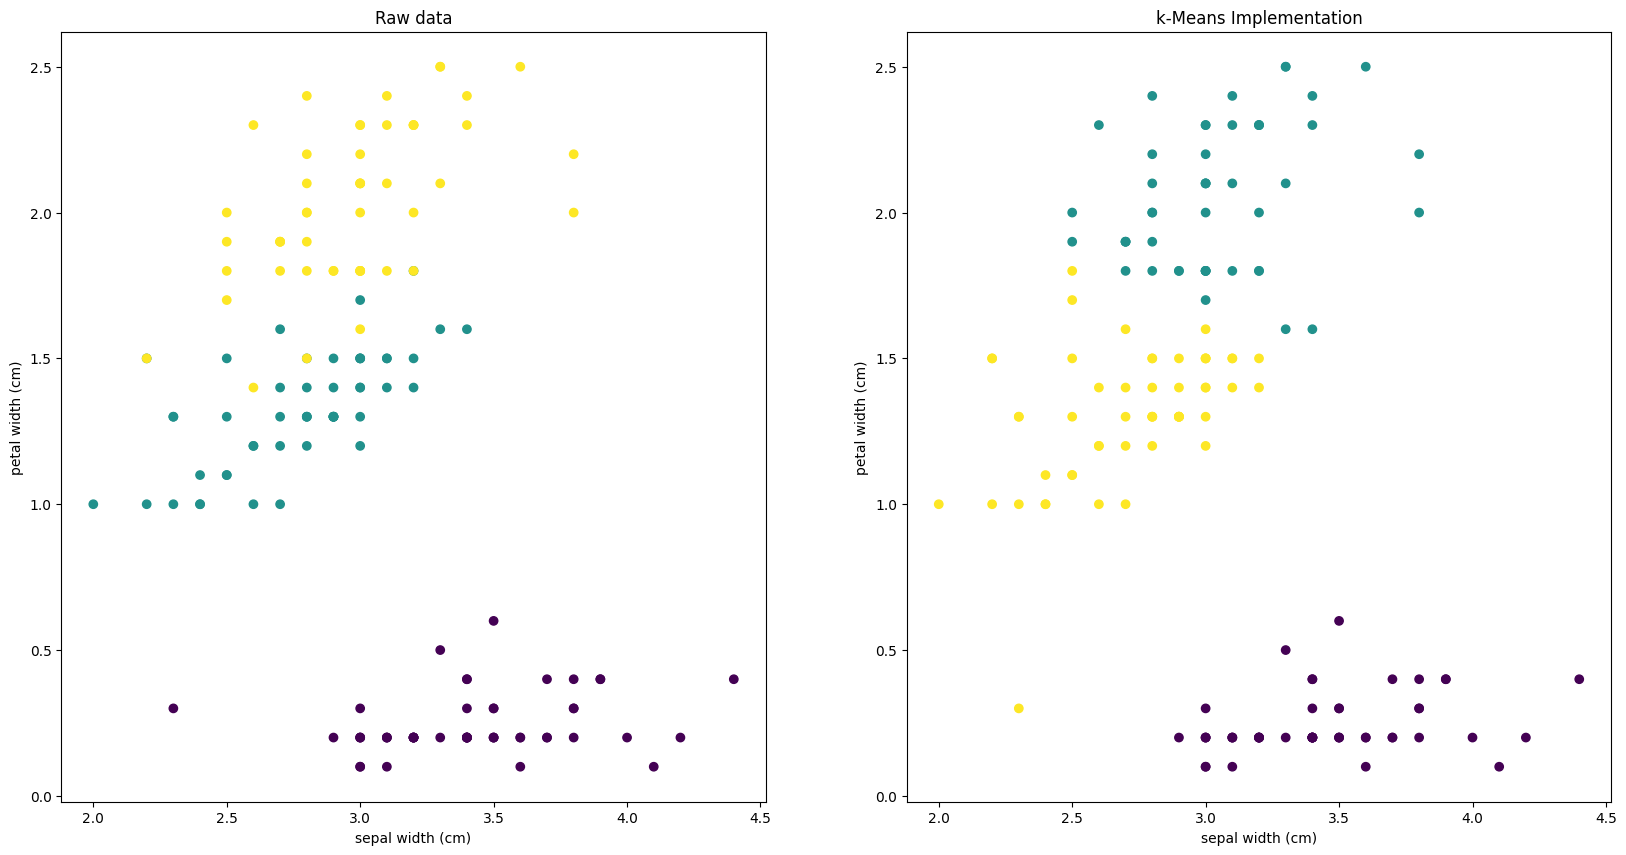

In [23]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)

plt.scatter(X[:, 0], X[:, 1], c=y.astype(float))

plt.xlabel(iris.feature_names[1], fontsize=10)
plt.ylabel(iris.feature_names[3], fontsize=10)

plt.title('Raw data')
plt.subplot( 1, 2, 2 )
# Plot the clusters we found.
plt.scatter(X[:, 0], X[:, 1], c=labels)

plt.xlabel(iris.feature_names[1], fontsize=10)
plt.ylabel(iris.feature_names[3], fontsize=10)

plt.title('k-Means Implementation')

### Built-In k-Means Clustering Algorithm

Text(0, 0.5, 'petal width (cm)')

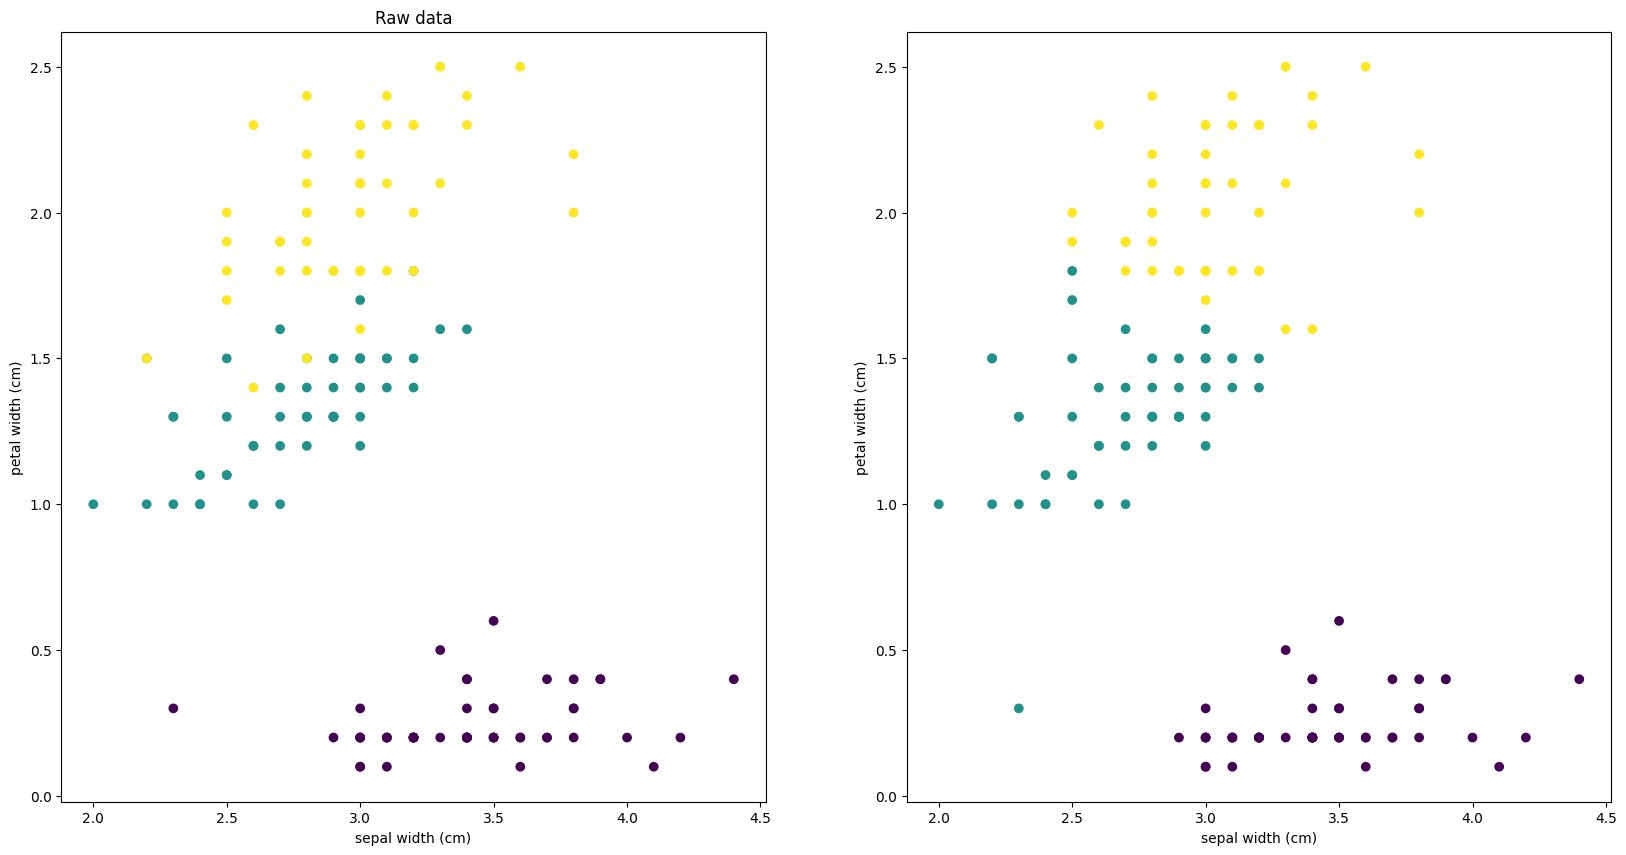

In [24]:
plt.figure(figsize=(20, 10))
plt.subplot( 1, 2, 1 )
# Plot the original data
plt.scatter(X[:, 0], X[:, 1], c=y.astype(float))

plt.xlabel( iris.feature_names[1], fontsize=10 )
plt.ylabel( iris.feature_names[3], fontsize=10 )

plt.title('Raw data')
plt.subplot( 1, 2, 2 )
# Plot the clusters we found.
plt.scatter(X[:, 0], X[:, 1], c=kM_labels)

plt.xlabel( iris.feature_names[1], fontsize=10 )
plt.ylabel( iris.feature_names[3], fontsize=10 )